# Task 4 Plotting Performance of models

In [2]:
import pandas as pd
import seaborn

## Define performances

Due to the impossibility for us to stop the updateStateByKey consumer once no more data have to be consumed. We had to manually stop the data consuming and we took screenshots to reuse here the different values of the models and we write them manually here. We only care for the last values so it is not a problem

In [17]:
persistance = pd.read_csv("streaming/Task1/persistance/part-00000", names=["Sensor", "MSE", "Error", "nb_pred"])
persistance["model"] = "persistance"
avg_2 = pd.read_csv("streaming/Task1/avg_2/part-00000", names=["Sensor", "MSE", "Error", "nb_pred"])
avg_2["model"] = "avg_2"
avg_3 = pd.read_csv("streaming/Task1/avg_3/part-00000", names=["Sensor", "MSE", "Error", "nb_pred"])
avg_3["model"] = "avg_3"
avg_4 = pd.read_csv("streaming/Task1/avg_4/part-00000", names=["Sensor", "MSE", "Error", "nb_pred"])
avg_4["model"] = "avg_4"
persistant_models = [persistance, avg_2, avg_3, avg_4]
persistant_models[0]
persistant_models = [x[["Sensor", "MSE", "model"]] for x in persistant_models]
performance_df = pd.concat(persistant_models).pivot(columns="Sensor", index="model", values="MSE")
performance_df

Sensor,CAT17,CB02411,CB1101,CB1142,CB1143,CB1599,CB1699,CB2105,CEE016,CEK049,CEK18,CEK31,CEV011,CJE181,CJM90,CLW239,COM205,CVT387
model,,,,,,,,,,,,,,,,,,
avg_2,60.99,128.76,58.12,289.82,111.62,21.52,19.25,64.13,119.75,74.42,100.79,104.43,22.08,7.55,243.67,17.99,38.72,19.40
avg_3,72.57,164.95,79.49,411.02,144.19,23.95,19.65,66.40,119.66,90.78,141.25,143.74,26.20,7.32,319.82,19.05,40.74,20.29
avg_4,86.92,209.27,102.11,533.86,183.34,26.95,21.07,71.41,122.43,110.14,184.01,187.19,30.73,7.40,405.09,20.79,45.00,21.83
persistance,60.18,114.21,44.62,194.58,97.18,22.46,21.95,73.72,127.05,72.42,71.01,80.96,21.06,9.47,198.93,20.20,44.24,21.51


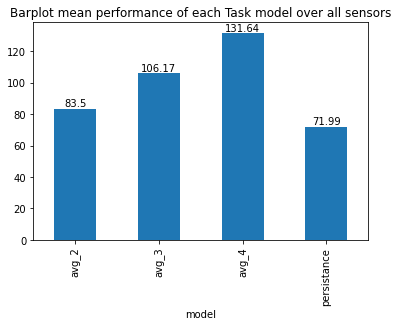

In [76]:
ax = performance_df.mean(axis=1).round(2).plot.bar(title="Barplot mean performance of each Task model over all sensors")
for container in ax.containers:
    ax.bar_label(container)

Let us compute the mean of the rank of the MSE for each models over each sensors

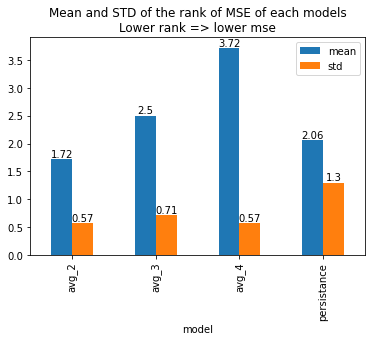

In [75]:
ax = performance_df.rank().agg(["mean", "std"],axis=1).round(2).plot.bar(title="Mean and STD of the rank of MSE of each models\nLower rank => lower mse")
for container in ax.containers:
    ax.bar_label(container)

It is apparent that the **avg_2** model has the lowest mean rank as well as the lowest std rank. As such we can consider it to outperform the other models

However we can see in the following plot that it happens sometimes that persistance is the best models compared to avg_2

<AxesSubplot:title={'center':'Barplot performance of each task model for each sensor'}, xlabel='Sensor'>

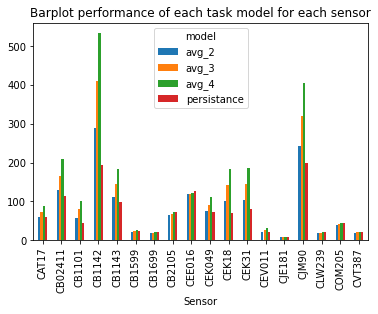

In [35]:
performance_df.T.plot.bar(title="Barplot performance of each task model for each sensor")

The model **Persistance** and **AVG 2** are the best model so far. 
From an analysis of the rank, the best model seems to be the avg_2 since it has lowest mean rank as well as the lowest std.

It would be interresting to observe the effect of a weighted average model in future works

## RLS Model

In [36]:
prefix = "streaming/RLS_Vanilla_N_"
data_frame_list = []
for i in range(1,5):
    data = pd.read_csv(f"{prefix}{i}/part-00000", names=["Sensor","MSE", "Error", "Nb_predictions"])
    data["N"] = i
    data_frame_list.append(data[["Sensor", "MSE", "N"]])
RLS_models = pd.concat(data_frame_list)

<AxesSubplot:xlabel='Sensor', ylabel='MSE'>

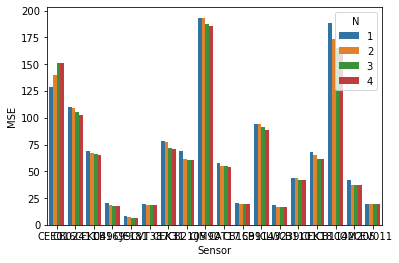

In [41]:
seaborn.barplot(data=RLS_models, x="Sensor", y="MSE", hue="N")

[Text(0.5, 1.0, 'Boxplot of the MSE of the RLS models depending on N')]

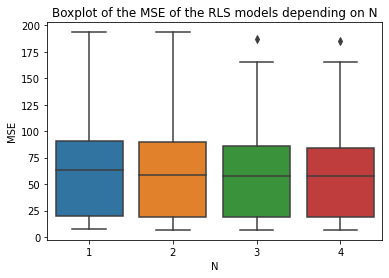

In [44]:
seaborn.boxplot(data=RLS_models, x="N", y="MSE").set(title="Boxplot of the MSE of the RLS models depending on N")

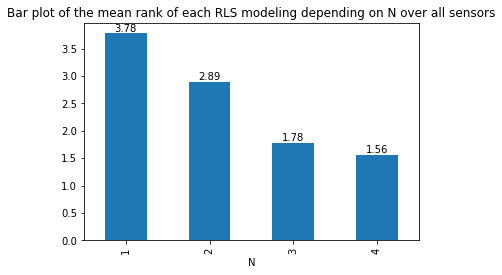

In [73]:
ax = RLS_models.pivot(index='N', columns='Sensor', values='MSE').rank().mean(axis=1).round(2).plot.bar(title="Bar plot of the mean rank of each RLS modeling depending on N over all sensors")
for container in ax.containers:
    ax.bar_label(container)

While the difference does not seem significant, N = 4 is the best performing model
We also tried before the a value of nu to 0.9 but it lead too to high error for our processor to execute

In [61]:
rls_4 = RLS_models.query("N == 4")
perf_avg_2 = pd.concat(persistant_models).query("model == 'avg_2'").drop("model", axis=1).rename(columns={"MSE": "avg_2"})
performances_comp_rls_vs_avg = pd.merge(rls_4, perf_avg_2, on="Sensor").rename(columns={"MSE": "RLS_4"}).set_index("Sensor").drop(["N"], axis=1)

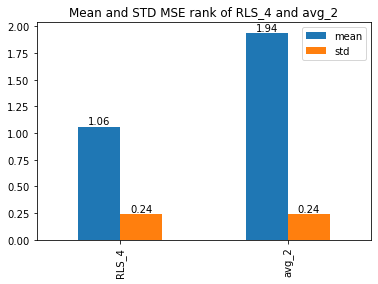

In [71]:
ax = performances_comp_rls_vs_avg.rank(axis=1).agg(["mean", "std"]).T.round(2).plot.bar(title="Mean and STD MSE rank of RLS_4 and avg_2")
for container in ax.containers:
    ax.bar_label(container)

We observe a significant difference between the performance of RLS_4 anf avg_2 where RLS_4 is clearly superior with a mean rank a bit higher than one

<AxesSubplot:title={'center':'Individual MSE for each Sensor between best avg_2 and RLS_4'}, xlabel='Sensor'>

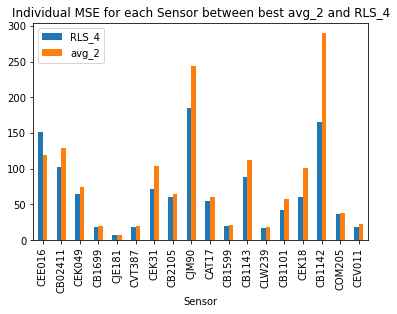

In [77]:
performances_comp_rls_vs_avg.plot.bar(title="Individual MSE for each Sensor between best avg_2 and RLS_4")

Both the rank comparison as well as the bar plot of performances shows the superiority of the RLS_4 model over the avg_2 model.

## Time Features RLS
In this section we test whether or not the addition of time related features improves the prediction of the RLS
We will do so by comparing the Time Related Features RLS versus the RLS - 4

In [67]:
time_feature_rls = pd.read_csv(f"streaming/RLS_TIME_4/part-00000", names=["Sensor","MSE", "Error", "Nb_predictions"])
time_feature_rls

,Sensor,MSE,Error,Nb_predictions
0,CEE016,189.08,5.663393e+06,29952
1,CB02411,100.58,3.012459e+06,29951
2,CEK049,62.90,1.884092e+06,29952
3,CB1699,18.23,5.459177e+05,29952
4,CJE181,6.62,1.981790e+05,29952
5,CVT387,18.95,5.677244e+05,29952
6,CEK31,70.63,2.115499e+06,29952
7,CB2105,61.97,1.856134e+06,29952
8,CJM90,184.85,5.536615e+06,29952
9,CAT17,50.81,1.521879e+06,29951


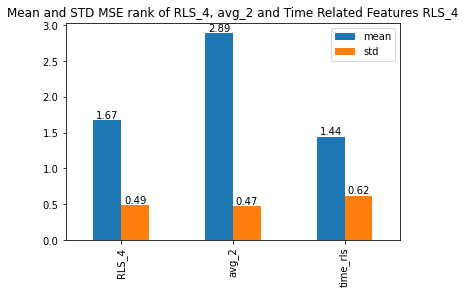

In [69]:
merged_prediction = pd.concat([performances_comp_rls_vs_avg, time_feature_rls.set_index("Sensor").drop(["Error", "Nb_predictions"], axis=1)["MSE"].rename("time_rls") ], axis=1)
ax = merged_prediction.dropna().rank(axis=1).agg(["mean", "std"]).round(2).T.plot.bar(title="Mean and STD MSE rank of RLS_4, avg_2 and Time Related Features RLS_4")
for container in ax.containers:
    ax.bar_label(container)

**time_rls** seems very slightly better but its std is higher than RLS_4 and the differance is not significant, however they clearly outperform avg_2$

We cannot conclude significant improvement of the Time Related RLS however this could be due to numerous factor such as the choice of hyperparameters such as nu, our preprocessing techniques, among other things